In [1]:
!pip install tabulate


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from IPython.display import display
import os
import pandas as pd
import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt
from settings import docs_path

from datetime import date

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from lightgbm import LGBMClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_validate,
    train_test_split
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
sns.set(style="whitegrid")

# Análise Exploratória

### Obtenção da base de dados

In [4]:
data = pd.read_csv(os.path.join(docs_path, 'data.csv'))

### Remoção de Dados

In [5]:
# Não será considerado partidas em que houve rendição cedo 
data = data[data['timePlayed'] > 900]

### Pré Processamento

Criação de novas variáveis geradas a partir da diferença entre as equipes

In [6]:
# Seleciona as colunas que começam com 'blue_side' e 'red_side'
blue_columns = data.filter(like='blue_side')
red_columns = data.filter(like='red_side')

# Calcula a diferença entre as colunas correspondentes
for blue_col, red_col in zip(blue_columns.columns, red_columns.columns):
    diff_col = f"{'_'.join(blue_col.split('_')[2:])}_diff"  # Cria o nome da coluna de diferença
    data[diff_col] = data[blue_col] - data[red_col]

Agrupamentos dos campeões pela sua classe

In [7]:
# Carregar os dados do JSON
file_path = os.path.join(docs_path, 'champion.json')
with open(file_path, 'r', encoding='utf-8') as file:
    champions = json.load(file)
    
# Criar novas colunas dos campeões para suas classes
champion_to_class = {champion.lower(): champion_data['tags'][0] for champion, champion_data in champions['data'].items()}
lane_columns = [col for col in data.columns if col.startswith('100_') or col.startswith('200_')]
for col in lane_columns:
    data[f'{col}_CLASS'] = data[col].apply(lambda x: champion_to_class.get(x.lower(), None))

### Visualização da base de dados

In [8]:
display(data)

,matchId,participants,endOfGameResult,timePlayed,gameVersion,gameEndedInSurrender,gameEndedInEarlySurrender,gameStartTimestamp,win,blue_side_baronKills,...,100_BOTTOM_CLASS,100_JUNGLE_CLASS,100_MIDDLE_CLASS,100_TOP_CLASS,100_UTILITY_CLASS,200_BOTTOM_CLASS,200_JUNGLE_CLASS,200_MIDDLE_CLASS,200_TOP_CLASS,200_UTILITY_CLASS
0,BR1_3010891752,"[""bJK3WphZHqsA6li6BhcivfO0vGRsgV_mMJDUhvmeFOce...",GameComplete,2249.354,14.20.623.6777,0,0,1.728968e+09,True,1,...,Mage,Fighter,Mage,Fighter,Support,Marksman,Tank,Mage,Fighter,Support
1,BR1_3010900586,"[""t1MptRkCqbuZLIerEjiY2-HUa3jBtMlCWBNdpMlUxSkV...",GameComplete,1830.368,14.20.623.6777,0,0,1.728971e+09,True,1,...,Mage,Fighter,Mage,Fighter,Support,Marksman,Mage,Mage,Fighter,Mage
2,BR1_3010910689,"[""RtPADu3TOFINdvaaLKYtoO4Kcmt4Rd4MIERMkCaUTYbe...",GameComplete,1829.868,14.20.623.6777,0,0,1.728978e+09,True,2,...,Mage,Tank,Marksman,Fighter,Support,Marksman,Fighter,Assassin,Fighter,Support
3,BR1_3010910840,"[""gP_dHfHa4JNW05lseUFfvj-WzOtxuroeRAAnynflaAbR...",GameComplete,1449.219,14.20.623.6777,0,0,1.728979e+09,True,1,...,Marksman,Assassin,Mage,Fighter,Support,Marksman,Assassin,Fighter,Fighter,Mage
4,BR1_3010911395,"[""bJK3WphZHqsA6li6BhcivfO0vGRsgV_mMJDUhvmeFOce...",GameComplete,1596.042,14.20.623.6777,0,0,1.728976e+09,True,1,...,Marksman,Assassin,Mage,Tank,Support,Marksman,Mage,Mage,Tank,Support
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19727,BR1_3045128640,"[""Vw_nF3i8D1ZS8eApyaikiObdLr7ikosNZp4S7ZUYFT2S...",GameComplete,1750.155,14.24.644.2327,0,0,1.735327e+09,True,0,...,Marksman,Fighter,Mage,Tank,Support,Marksman,Assassin,Mage,Fighter,Support
19728,BR1_3045138141,"[""BetEIxrtAIlInNcpH5zk2oKYrpG5eyP34cJg6q7LiVYf...",GameComplete,935.708,14.24.644.2327,1,0,1.735328e+09,True,0,...,Marksman,Marksman,Fighter,Mage,Tank,Mage,Mage,Fighter,Fighter,Marksman
19729,BR1_3045142382,"[""PytDMbfTsWLh2XHFtSiy752dRlHTBbBOBbRBP8X_meOK...",GameComplete,1164.522,14.24.644.2327,1,0,1.735329e+09,False,0,...,Marksman,Assassin,Mage,Fighter,Support,Marksman,Assassin,Mage,Fighter,Tank
19730,BR1_3045147939,"[""eamCq4fpOIwlJSenO93uikhfiI05vRWHjKSaeO-jn7xr...",GameComplete,1136.510,14.24.644.2327,1,0,1.735330e+09,True,0,...,Mage,Mage,Fighter,Fighter,Support,Marksman,Assassin,Fighter,Fighter,Tank


### Verificação dos tipos das variáveis

In [9]:
dtypes_data = pd.DataFrame(data.dtypes)
print(dtypes_data)

                         0
matchId             object
participants        object
endOfGameResult     object
timePlayed         float64
gameVersion         object
...                    ...
200_BOTTOM_CLASS    object
200_JUNGLE_CLASS    object
200_MIDDLE_CLASS    object
200_TOP_CLASS       object
200_UTILITY_CLASS   object

[156 rows x 1 columns]


In [10]:
data['win'] = data['win'].astype(int)

### Análise de Unicidade e Missings

In [11]:
print(f"Nº de registros duplicados:\n{data.duplicated(subset = 'matchId').sum()}\n")

print(f"Quantidade de valores nulos por colunas:\n{data.isnull().sum()}")

Nº de registros duplicados:
0

Quantidade de valores nulos por colunas:
matchId              0
participants         0
endOfGameResult      0
timePlayed           0
gameVersion          0
                    ..
200_BOTTOM_CLASS     0
200_JUNGLE_CLASS     0
200_MIDDLE_CLASS     0
200_TOP_CLASS        0
200_UTILITY_CLASS    0
Length: 156, dtype: int64


### Análise Univariada

In [12]:
data.describe()

,timePlayed,gameEndedInSurrender,gameEndedInEarlySurrender,gameStartTimestamp,win,blue_side_baronKills,red_side_baronKills,blue_side_dragonKills,red_side_dragonKills,blue_side_riftHeraldKills,...,total_damage_taken_diff,total_damage_dealt_to_champions_diff,total_heal_diff,total_time_ccing_others_diff,total_minions_killed_diff,total_neutral_minions_killed_diff,total_time_spent_dead_diff,total_detector_wards_placed_diff,total_vision_wards_bought_in_game_diff,total_wards_placed_diff
count,19039.000000,19039.000000,19039.0,1.903900e+04,19039.000000,19039.000000,19039.000000,19039.000000,19039.000000,19039.000000,...,19039.000000,19039.000000,19039.000000,19039.000000,19039.000000,19039.000000,19039.000000,19039.000000,19039.000000,19039.000000
mean,1620.682470,0.305373,0.0,1.730931e+09,0.526341,0.478386,0.482483,1.478019,1.802773,0.518094,...,-1005.510058,1157.477336,-156.487631,1.460108,-1.396502,-0.026682,-17.536373,0.017806,-0.011555,0.192184
std,384.966776,0.460577,0.0,1.372873e+06,0.499319,0.639790,0.653962,1.191166,1.274707,0.499686,...,20135.079001,23135.840399,20492.938524,52.243730,60.735841,34.072384,351.127399,6.916916,7.784623,14.655428
min,900.109000,0.000000,0.0,1.728968e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-117581.000000,-86490.000000,-156501.000000,-394.000000,-308.000000,-202.000000,-1173.000000,-39.000000,-41.000000,-166.000000
25%,1371.673500,0.000000,0.0,1.729963e+09,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,-13524.000000,-16343.500000,-11178.500000,-26.000000,-44.000000,-21.000000,-304.000000,-4.000000,-5.000000,-8.000000
50%,1624.031000,0.000000,0.0,1.730748e+09,1.000000,0.000000,0.000000,1.000000,2.000000,1.000000,...,-1153.000000,2234.000000,189.000000,1.000000,-1.000000,0.000000,-46.000000,0.000000,0.000000,0.000000
75%,1870.537500,1.000000,0.0,1.731557e+09,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,...,11369.500000,18358.000000,11096.500000,28.000000,41.000000,22.000000,278.000000,4.000000,5.000000,9.000000
max,3648.269000,1.000000,0.0,1.735332e+09,1.000000,4.000000,4.000000,6.000000,6.000000,1.000000,...,91817.000000,90580.000000,149808.000000,439.000000,230.000000,221.000000,1073.000000,44.000000,46.000000,127.000000


#### Distribuição das Variáveis

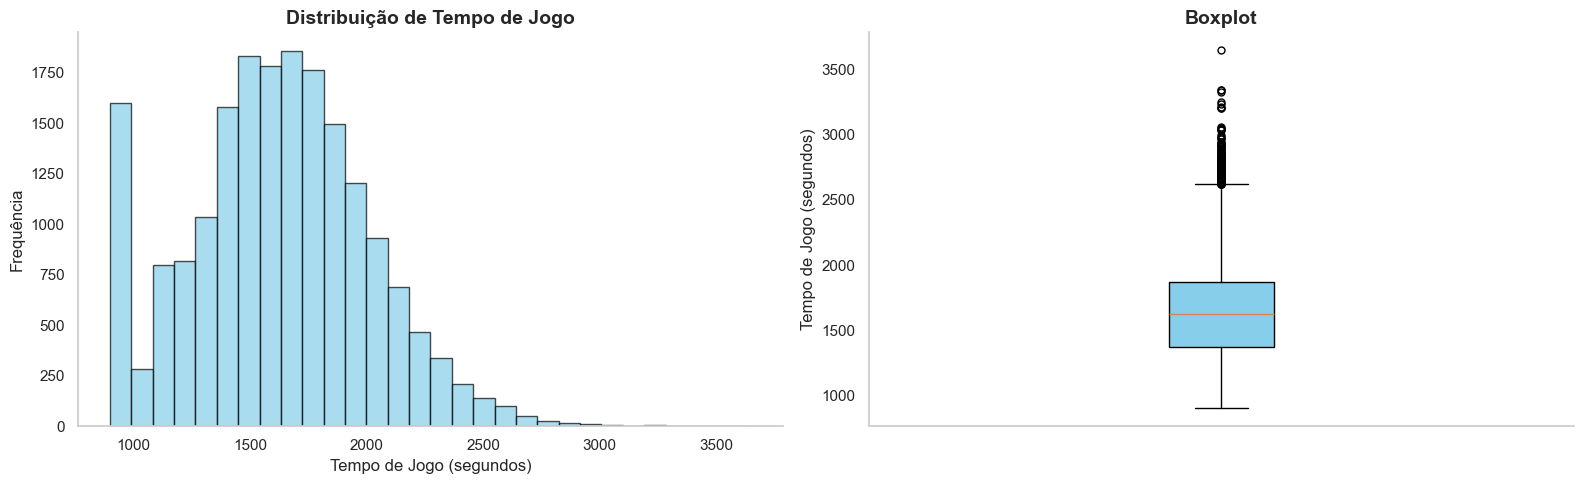

In [13]:
# Configuração do tamanho da figura
fig, axs = plt.subplots(1, 2, figsize=(16, 5))  # 1 linha, 2 colunas

# Histograma
axs[0].hist(data['timePlayed'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axs[0].set_title('Distribuição de Tempo de Jogo', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Tempo de Jogo (segundos)', fontsize=12)
axs[0].set_ylabel('Frequência', fontsize=12)
axs[0].grid(False)

# Removendo as bordas
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# Boxplot
axs[1].boxplot(data['timePlayed'], vert=True, patch_artist=True, 
               boxprops=dict(facecolor='skyblue', color='black'),
               whiskerprops=dict(color='black'), flierprops=dict(marker='o', color='red', markersize=5))
axs[1].set_title('Boxplot', fontsize=14, fontweight='bold')
axs[1].set_ylabel('Tempo de Jogo (segundos)', fontsize=12)
axs[1].set_xticks([])
axs[1].grid(False)

# Removendo bordas
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

# Ajustando o layout para não sobrepor os gráficos
plt.tight_layout()

# Exibindo os gráficos
plt.show()


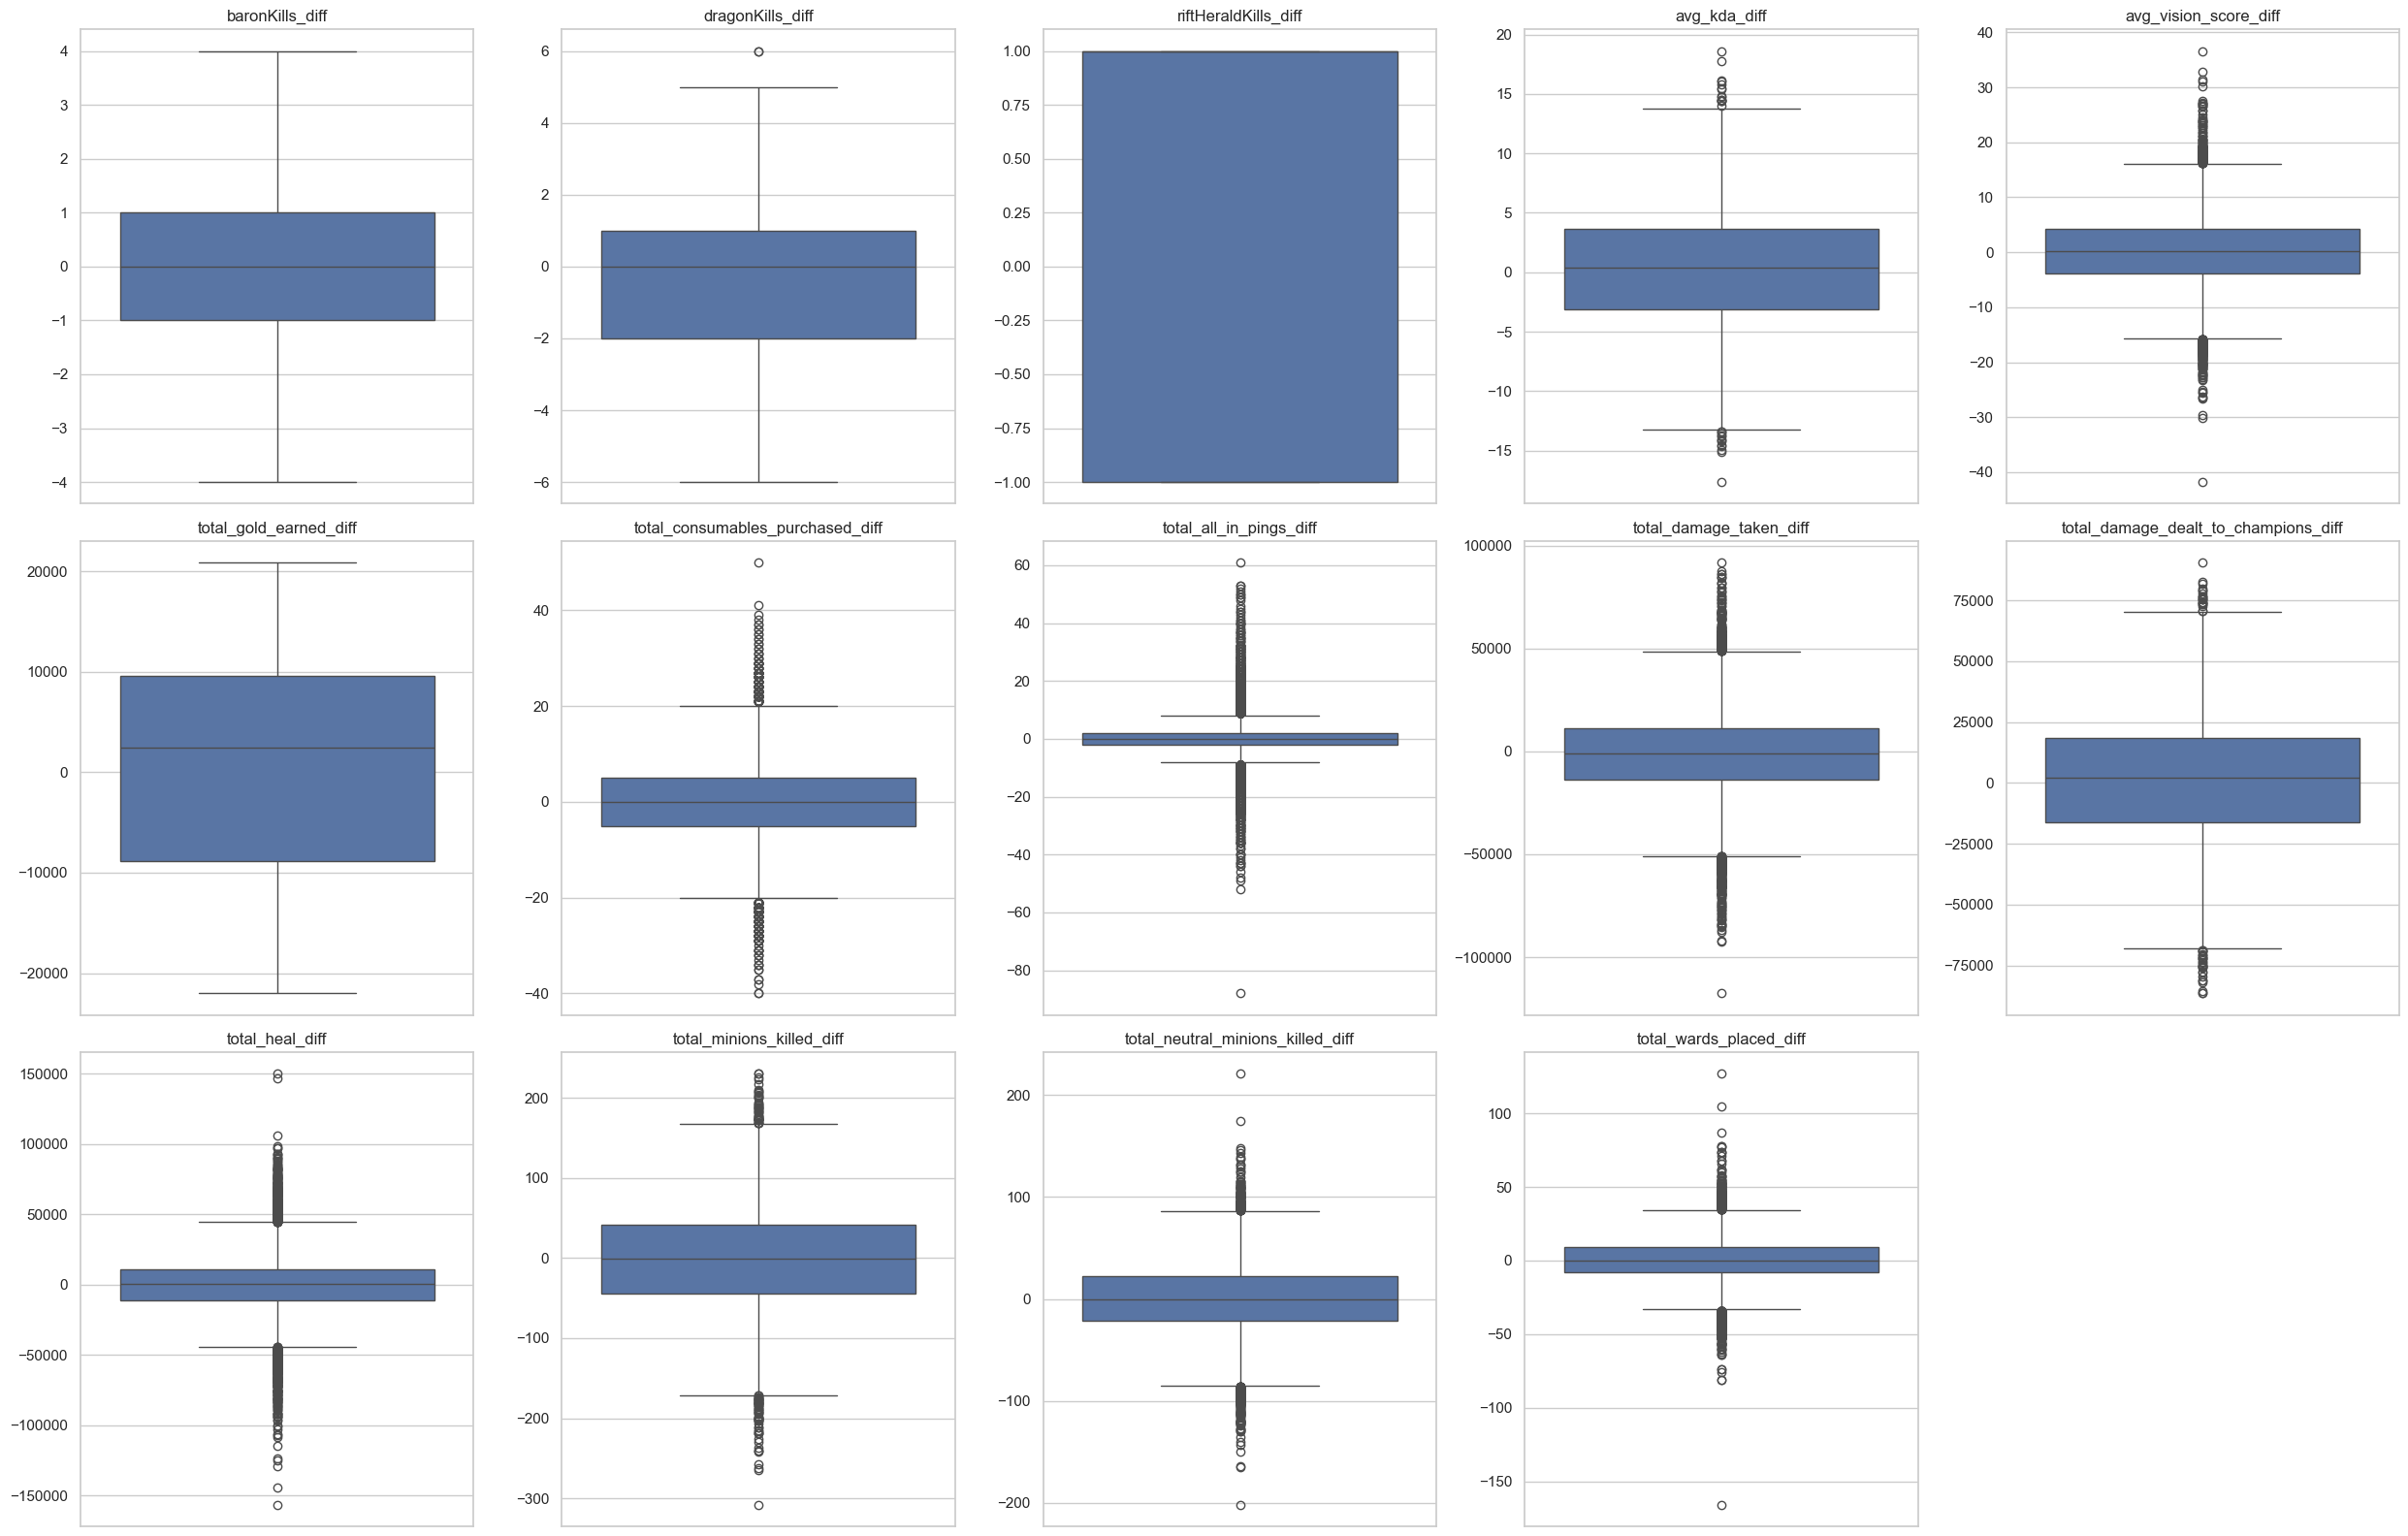

In [14]:
data_num = data[['baronKills_diff', 'dragonKills_diff', 'riftHeraldKills_diff', 'avg_kda_diff', 
                 'avg_vision_score_diff', 'total_gold_earned_diff', 'total_consumables_purchased_diff',
                'total_all_in_pings_diff', 'total_damage_taken_diff', 'total_damage_dealt_to_champions_diff',
                'total_heal_diff', 'total_minions_killed_diff', 'total_neutral_minions_killed_diff',
                'total_wards_placed_diff']]

num_cols = 5
num_rows = (len(data_num.columns) // num_cols) + (1 if len(data_num.columns) % num_cols > 0 else 0)

plt.figure(figsize=(25, 16))
for i, col in enumerate(data_num.columns):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(y=data_num[col])
    ax.set_title(col)
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

#### Proporção de Vitórias

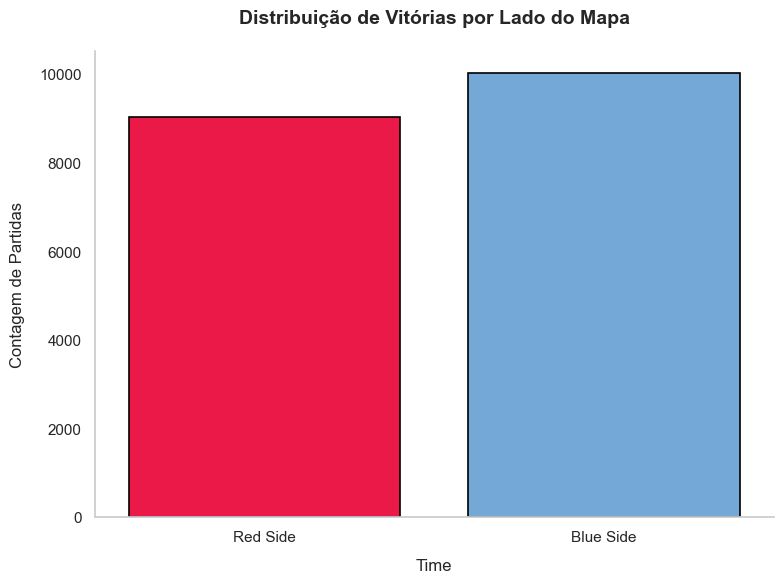

In [15]:
# Configurações de estilo
sns.set_palette(['#F70D42', '#6FA8DC'])

# Criar figura com tamanho otimizado
plt.figure(figsize=(8, 6), dpi=100)

# Gráfico countplot melhorado
ax = sns.countplot(
    x='win',
    data=data,
    edgecolor='black',
    hue='win',
    palette=['#F70D42', '#6FA8DC'],
    linewidth=1.2,
    saturation=0.9,
    legend=False
)

# Personalização do título e rótulos
plt.title('Distribuição de Vitórias por Lado do Mapa',
          fontsize=14,
          pad=20,
          fontweight='bold')

plt.xlabel('Time', fontsize=12, labelpad=10)
plt.ylabel('Contagem de Partidas', fontsize=12, labelpad=10)
plt.xticks([0, 1], ['Red Side', 'Blue Side'], fontsize=11)

# Remoção do grid
ax.grid(False)

# Removendo bordas
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

#### Top 5 campeões mais jogados por posição e lado

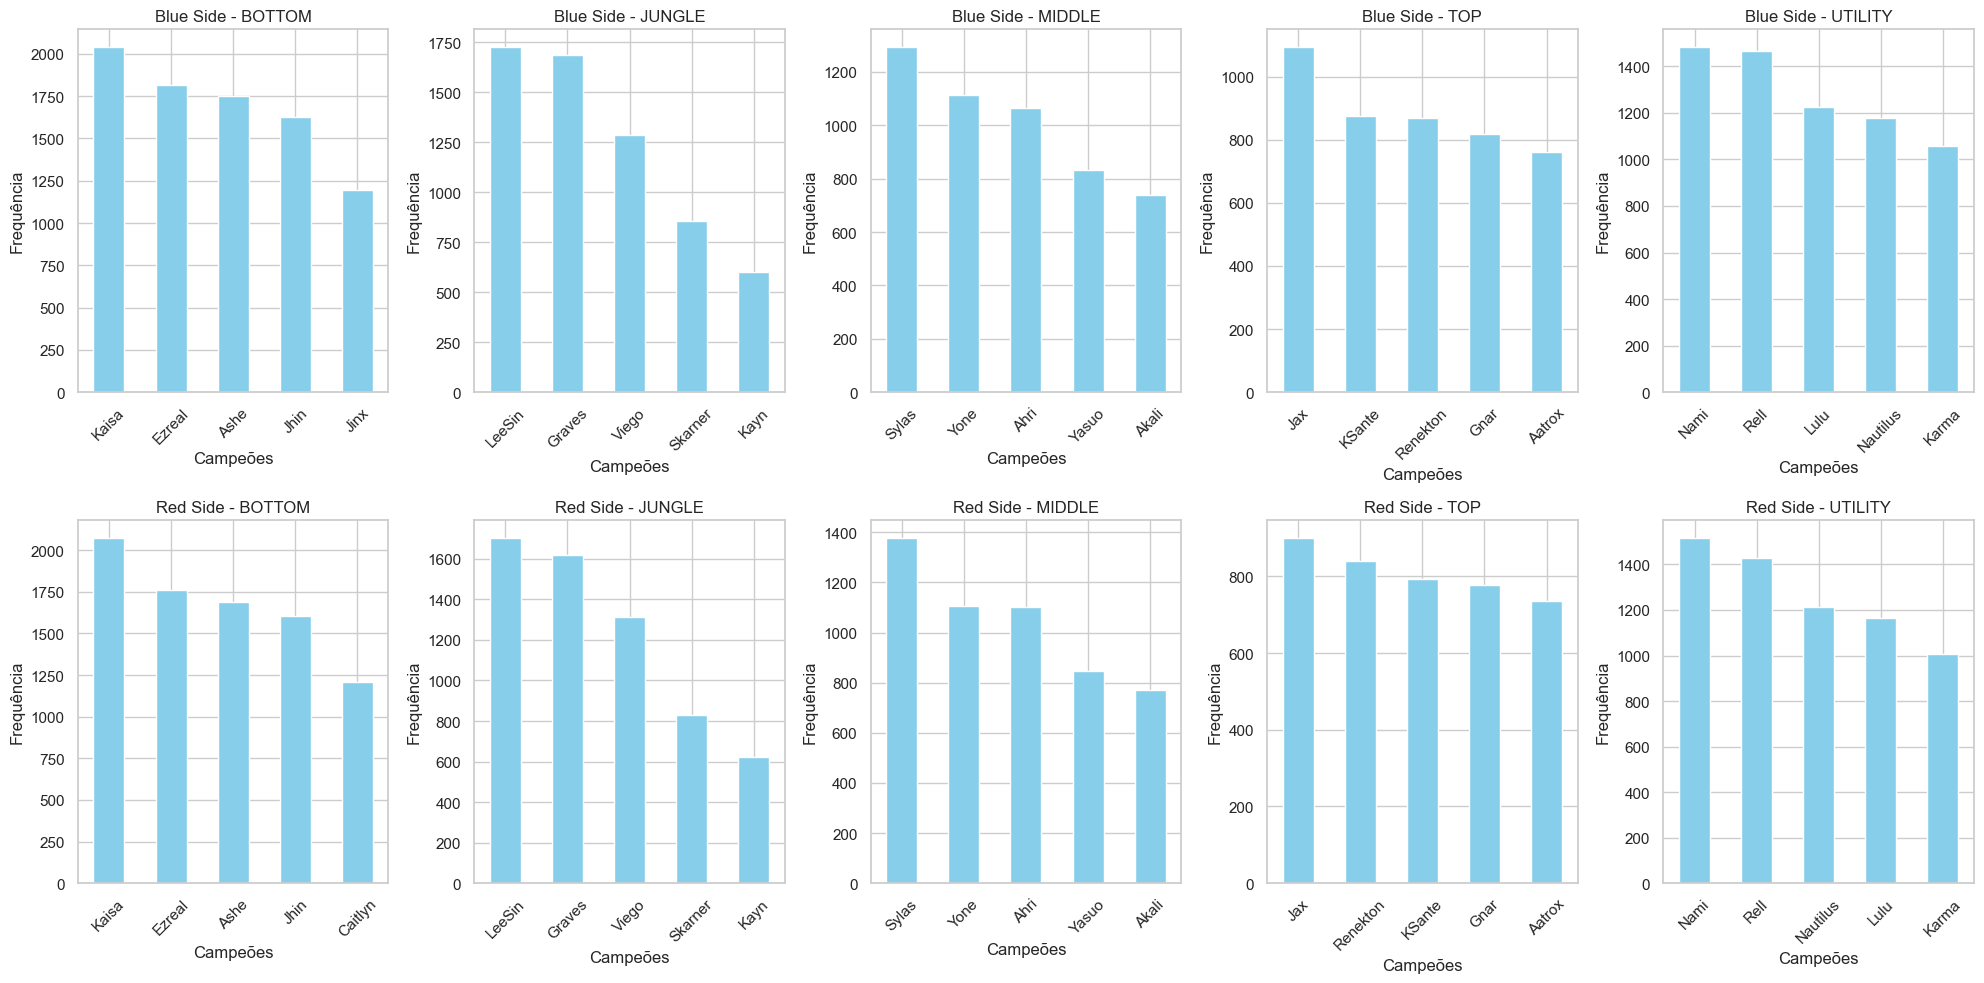

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten() 

lane_columns = [col for col in data.columns if col.startswith('100_') or col.startswith('200_')]

for i, col in enumerate(lane_columns[:10]):
    freq = data[col].value_counts()
    top_freq = freq.head(5)

    side = "Blue Side" if col.startswith("100_") else "Red Side"
    lane = col.split('_')[1] 
    title = f'{side} - {lane}'
    
    ax = axes[i]
    top_freq.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(title)
    ax.set_xlabel('Campeões')
    ax.set_ylabel('Frequência')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Frequência das classes em cada Lane

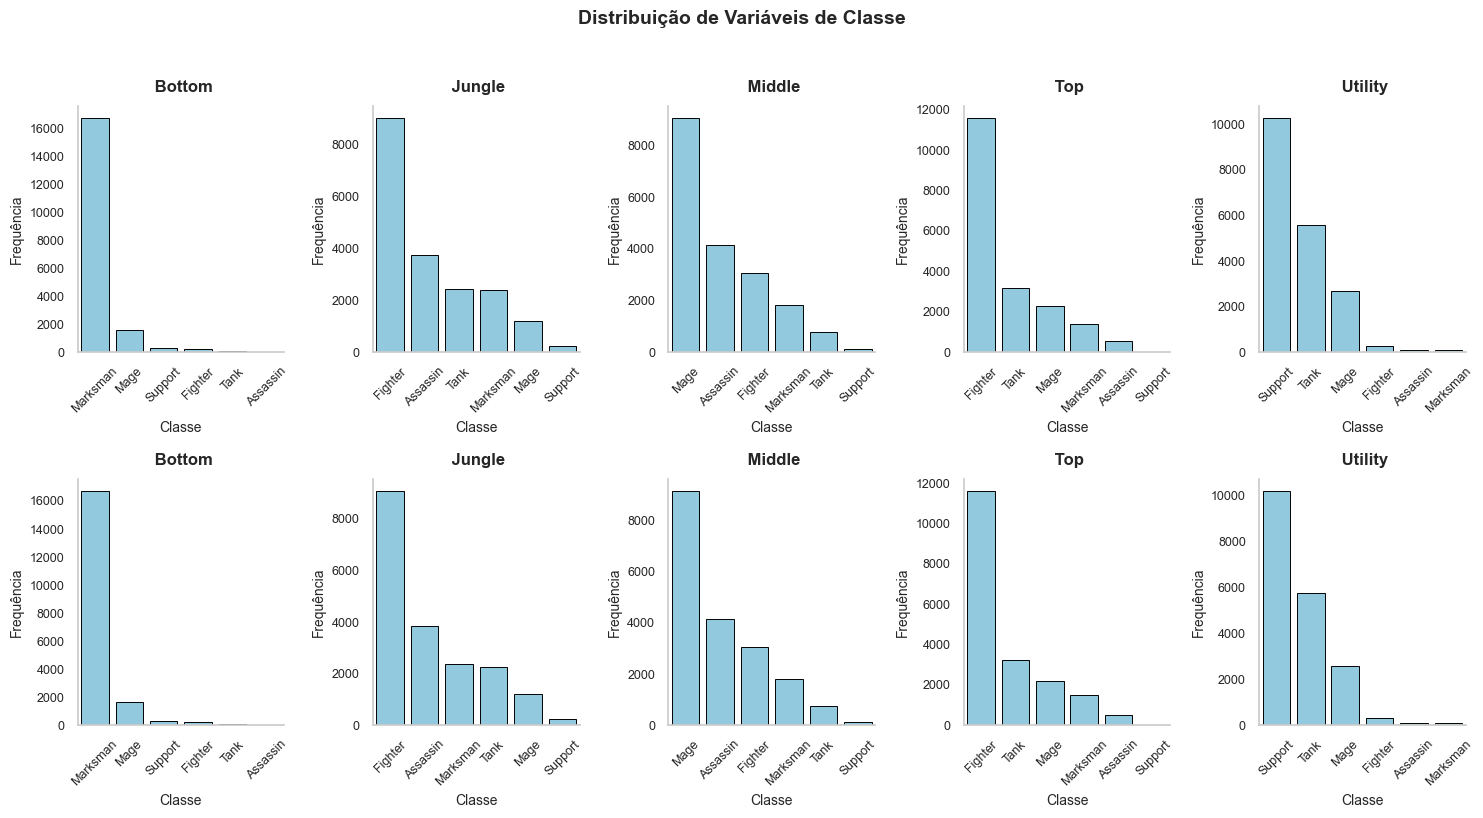

In [17]:
# Filtrando colunas de classe
class_columns = data.filter(like='_CLASS')

# Criar a estrutura do grid 2x5
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Gerar gráficos individuais
for ax, col in zip(axes.flat, class_columns.columns):
    class_counts = class_columns[col].value_counts()
    
    # BarPlot
    sns.barplot(
        x=class_counts.index, 
        y=class_counts.values, 
        ax=ax,
        color='skyblue',
        edgecolor='black',
        linewidth=0.7
    )

    # Ajuste de rótulos e título
    title = col.replace('_CLASS', '').replace('_', ' ').replace('100', '').replace('200', '').title()
    ax.set_title(title, fontsize=12, pad=10, weight='bold')
    ax.set_xlabel('Classe', fontsize=10)
    ax.set_ylabel('Frequência', fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.tick_params(axis='y', labelsize=9)

    # Removendo grid
    ax.grid(False)

    # Removendo e ajustando bordas
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Esconder eixos vazios (caso tenha menos que 10 colunas)
for ax in axes.flat[len(class_columns.columns):]:
    ax.axis('off')

fig.suptitle('Distribuição de Variáveis de Classe', 
             y=1.02, fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

### Análise Bivariada

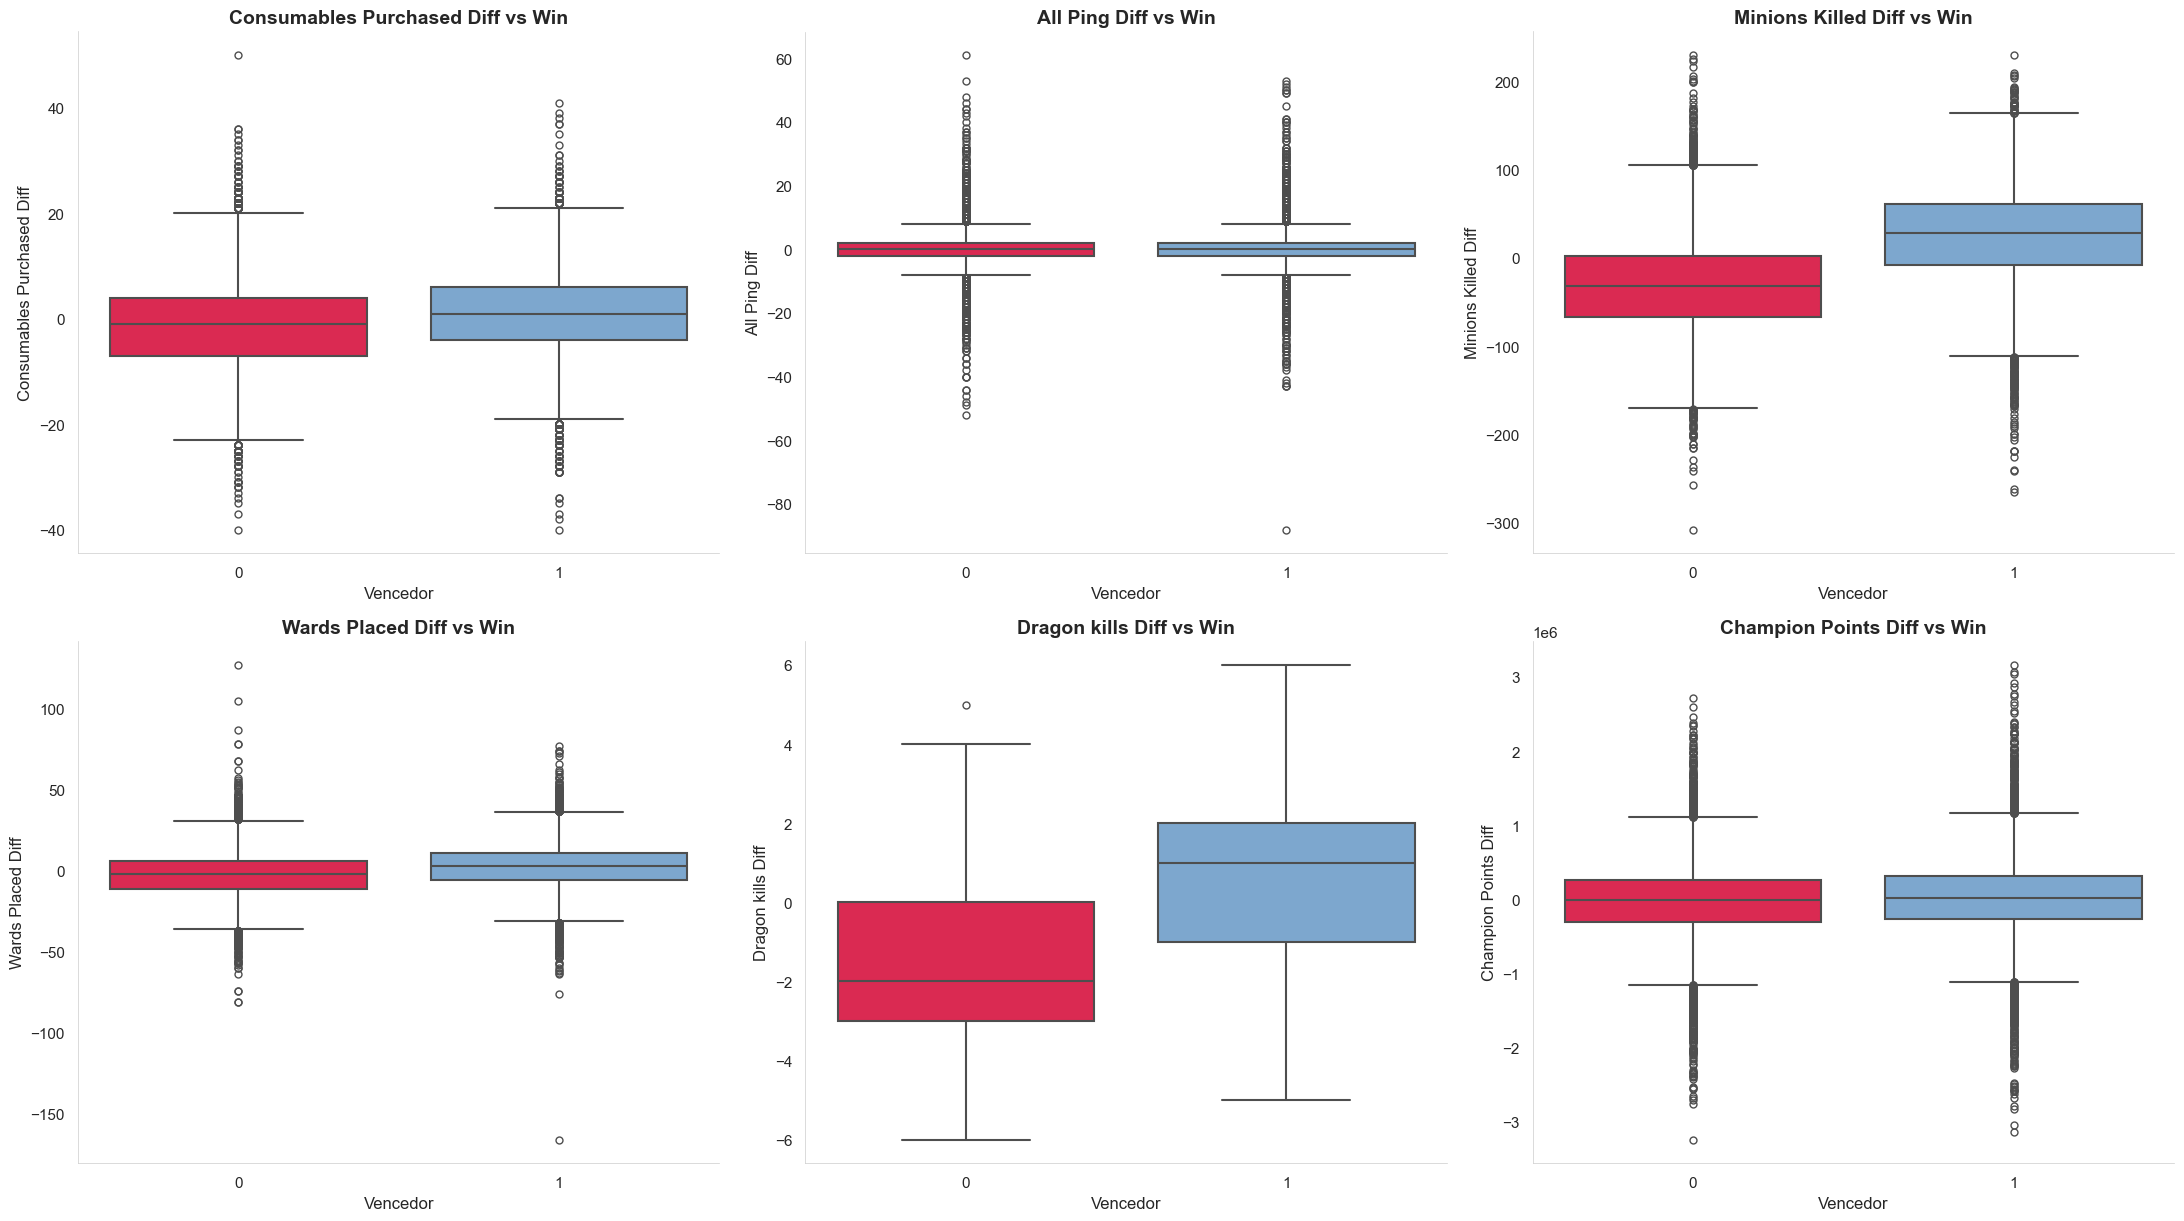

In [18]:
numerical_variables = [
    'total_consumables_purchased_diff', 'total_all_in_pings_diff', 'total_minions_killed_diff', 'total_wards_placed_diff',
    'dragonKills_diff', 'avg_champion_points_diff'
]

y_label = ['Consumables Purchased Diff', 'All Ping Diff', 'Minions Killed Diff', 'Wards Placed Diff', 'Dragon kills Diff', 
           'Champion Points Diff']


# Configuração do tamanho da figura para melhor legibilidade
plt.figure(figsize=(22, 18))

# Loop para plotar cada boxplot
for i, col in enumerate(numerical_variables):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=data, x='win', y=col, hue='win', palette=['#F70D42', '#6FA8DC'], fliersize=5, linewidth=1.5, legend=False)
    
    # Removendo e ajustando bordas
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_linewidth(0.5)
    plt.gca().spines['bottom'].set_linewidth(0.5)
    
    # Ajuste de grid
    plt.grid(False) 
    
    # Ajuste de rótulos e título
    plt.xlabel('Vencedor', fontsize=12)
    plt.ylabel(y_label[i], fontsize=12)
    plt.title(f'{y_label[i]} vs Win', fontsize=14, fontweight='bold')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo os gráficos
plt.show()

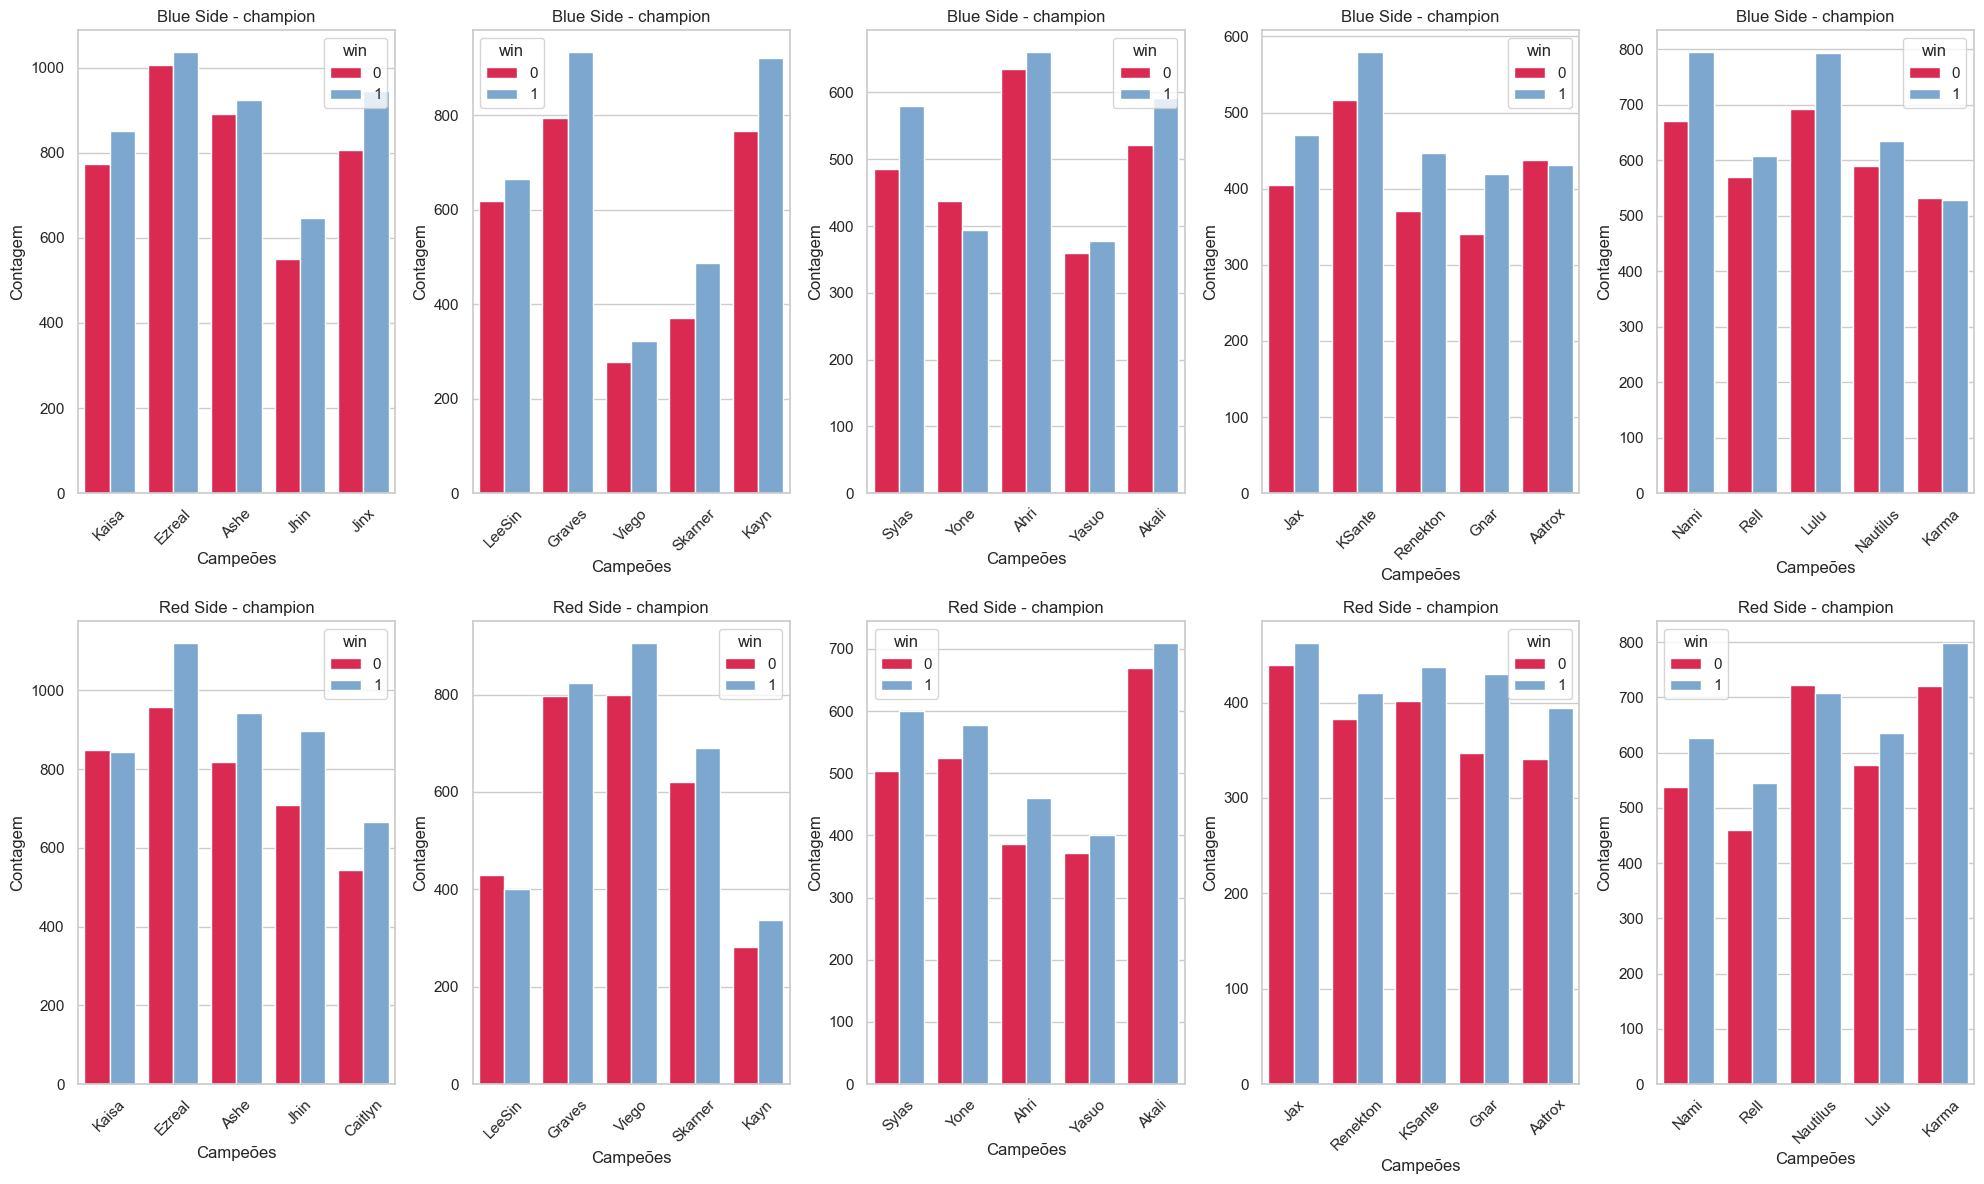

In [19]:
fig, axes = plt.subplots(2, 5, figsize=(20, 12))
axes = axes.flatten()

for i, lane in enumerate(lane_columns[:10]):
    top_champions = data[lane].value_counts().nlargest(5).index
    sns.countplot(x=lane, data=data[data[lane].isin(top_champions)], hue='win', ax=axes[i])
    
    side = "Blue Side" if lane.startswith("100_") else "Red Side"
    lane = col.split('_')[1]
    title = f'{side} - {lane}'
    
    axes[i].set_title(title)
    
    axes[i].set_xticks(range(5))
    axes[i].set_xticklabels(top_champions, rotation=45)
    axes[i].set_ylabel('Contagem')
    axes[i].set_xlabel('Campeões')
    
plt.tight_layout()
plt.show()


# Regressão Logística

## Separação das bases

In [91]:
data['gameStartDate'] = pd.to_datetime(data['gameStartDate']).dt.date

data_train = data[data['gameStartDate'] < date(2024,12,1)]
data_validation = data[data['gameStartDate'] > date(2024,12,1)]

In [100]:
# Agrupamento das colunas
### Variável resposta
winner = [
    'win'
]
### Informações pré-jogo
pre_game = [
    'avg_summoner_level_diff',
    'avg_tier_rank_diff',
    'avg_champion_win_rate_diff', 
    'avg_champion_pick_rate_diff',
    'avg_rune_win_rate_diff', 
    'avg_rune_pick_rate_diff',
    'avg_champion_points_diff',
    '100_BOTTOM_CLASS', 
    '100_JUNGLE_CLASS', 
    '100_MIDDLE_CLASS',
    '100_TOP_CLASS', 
    '100_UTILITY_CLASS', 
    '200_BOTTOM_CLASS',
    '200_JUNGLE_CLASS', 
    '200_MIDDLE_CLASS', 
    '200_TOP_CLASS', 
    '200_UTILITY_CLASS'
]
### Objetivos neutros conquistados
neutral_goals = [
    'dragonKills_diff',
    'riftHeraldKills_diff',
    'total_minions_killed_diff',
    'total_neutral_minions_killed_diff'
]
### Pontuação relacionada a visão
vision = [
    'avg_vision_score_diff',
    'total_detector_wards_placed_diff',
    'total_vision_wards_bought_in_game_diff', 
    'total_wards_placed_diff'
]
### Comunicação no jogo
comunication = [
    'total_all_in_pings_diff',
    'total_assist_me_pings_diff', 
    'total_command_pings_diff',
    'total_enemy_missing_pings_diff',
    'total_enemy_vision_pings_diff',
    'total_get_back_pings_diff', 
    'total_need_vision_pings_diff',
    'total_on_my_way_pings_diff', 
    'total_push_pings_diff'
]
### Estatísticas
estatistica = [
    'avg_kda_diff',
    'total_kills_diff', 
    'total_assists_diff',
    'avg_longest_time_spent_living_diff',
    'total_time_spent_dead_diff'
]
### Performance
performance = [
    'total_damage_taken_diff',
    'total_damage_dealt_to_champions_diff',
    'total_heal_diff',
    'total_time_ccing_others_diff',
    'total_consumables_purchased_diff'
]

## Modelagem 1 - Informações Pré-Jogo

Inicialmente começaremos com um modelo apenas com as variáveis relacionadas ao pré-game, e a fase de seleção dos campeões, antes mesmo dos jogadores começarem a de fato jogarem o jogo.

### Ajuste do Modelo

In [22]:
data_train_model_1 = data_train[winner + pre_game].copy()
data_validatation_model_1 = data_validation[winner + pre_game].copy()

In [23]:
# Remoção de conlunas estatísticamente insignificante
remove_columns_model_1 = [
    '100_UTILITY_CLASS', '200_MIDDLE_CLASS', 'avg_rune_pick_rate_diff', '200_BOTTOM_CLASS', 
    '200_UTILITY_CLASS', '100_MIDDLE_CLASS', '200_TOP_CLASS', '100_JUNGLE_CLASS',
    '100_BOTTOM_CLASS', 'avg_champion_pick_rate_diff', 'avg_champion_win_rate_diff'
]

data_train_model_1 = data_train_model_1.drop(columns = remove_columns_model_1)
features = [col for col in pre_game if col not in remove_columns_model_1]

# Adicionar `Q()` para colunas que começam com números
features = [f'Q("{col}")' if any(char.isdigit() for char in col.split('_')[0]) else col for col in features]

In [24]:
formula = 'win ~ ' + ' + '.join(features)
model_1 = smf.logit(formula,
                   data = data_train_model_1).fit() 

print(model_1.summary())

Optimization terminated successfully.
         Current function value: 0.550080
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                17752
Model:                          Logit   Df Residuals:                    17737
Method:                           MLE   Df Model:                           14
Date:                Mon, 31 Mar 2025   Pseudo R-squ.:                  0.2048
Time:                        13:42:28   Log-Likelihood:                -9765.0
converged:                       True   LL-Null:                       -12280.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.3318      0.109      3

In [25]:
vif = pd.DataFrame({
    "Variável": model_1.model.exog_names,
    "VIF": [variance_inflation_factor(model_1.model.exog, i) for i in range(model_1.model.exog.shape[1])]
})

print(vif)

                             Variável        VIF
0                           Intercept  38.385358
1       Q("100_TOP_CLASS")[T.Fighter]   8.612270
2          Q("100_TOP_CLASS")[T.Mage]   4.486491
3      Q("100_TOP_CLASS")[T.Marksman]   3.247261
4       Q("100_TOP_CLASS")[T.Support]   1.039897
5          Q("100_TOP_CLASS")[T.Tank]   5.698547
6    Q("200_JUNGLE_CLASS")[T.Fighter]   1.767311
7       Q("200_JUNGLE_CLASS")[T.Mage]   1.236664
8   Q("200_JUNGLE_CLASS")[T.Marksman]   1.433204
9    Q("200_JUNGLE_CLASS")[T.Support]   1.049119
10      Q("200_JUNGLE_CLASS")[T.Tank]   1.402500
11            avg_summoner_level_diff   1.101086
12                 avg_tier_rank_diff   1.002466
13             avg_rune_win_rate_diff   1.023095
14           avg_champion_points_diff   1.114319


### Aplicação do modelo e definição de resposta predita

In [26]:
def calcular_metricas(data):
    table = pd.crosstab(data['win'], data['pred'])
    acuracia = (table.iloc[0, 0] + table.iloc[1, 1]) / table.sum().sum()
    especificidade = table.iloc[0, 0] / (table.iloc[0, 0] + table.iloc[0, 1])
    sensibilidade = table.iloc[1, 1] / (table.iloc[1, 0] + table.iloc[1, 1])

    fpr, tpr, _ = roc_curve(data['win'], data['prob'])
    ks = max(tpr - fpr)

    auc_score = roc_auc_score(data['win'], data['prob'])

    return [acuracia, especificidade, sensibilidade, ks, auc_score]

In [27]:
# Aplicação do modelo na base de treino e validação
data_train_model_1['prob'] = model_1.predict(data_train_model_1.drop('win', axis=1))
data_validatation_model_1['prob'] = model_1.predict(data_validatation_model_1.drop('win', axis=1))

# Definição de ponto de corte
ponto_corte = data_train_model_1['win'].mean()
print(ponto_corte)

# Definição da resposta predita pelo modelo
data_train_model_1['pred'] = (data_train_model_1['prob'] > ponto_corte).astype(int)
data_validatation_model_1['pred'] = (data_validatation_model_1['prob'] > ponto_corte).astype(int)

0.5264195583596214


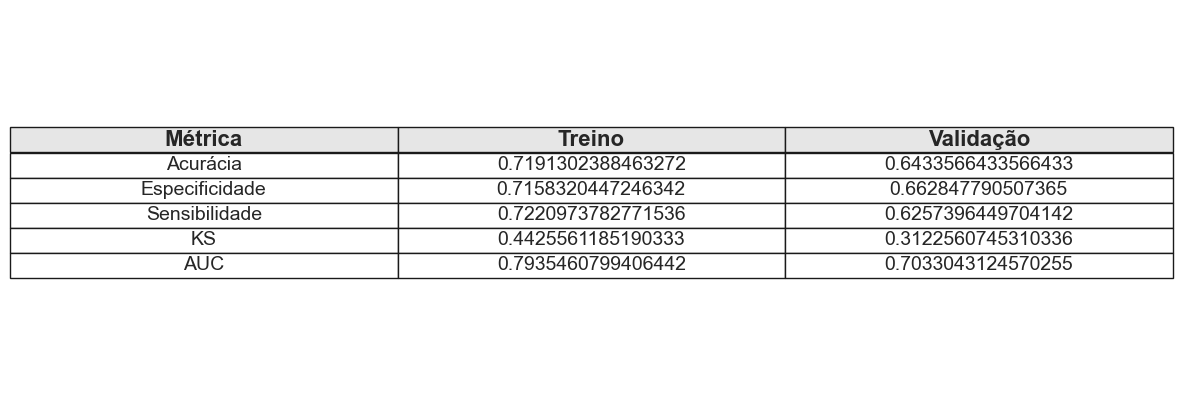

In [28]:
# Tabela consolidada
resultados = pd.DataFrame({
    'Métrica': ['Acurácia', 'Especificidade', 'Sensibilidade', 'KS', 'AUC'],
    'Treino': calcular_metricas(data_train_model_1),
    'Validação': calcular_metricas(data_validatation_model_1)
})

# Criar figura e eixo com um tamanho maior
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')

# Adiciona a tabela
table = ax.table(cellText=resultados.values, 
                colLabels=resultados.columns, 
                cellLoc='center', 
                loc='center',
                colColours=['#f2f2f2'] * len(resultados.columns))

# Ajustar o estilo da tabela
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.5)

for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(16)
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#e6e6e6')
    else:
        cell.set_fontsize(14)

plt.show()

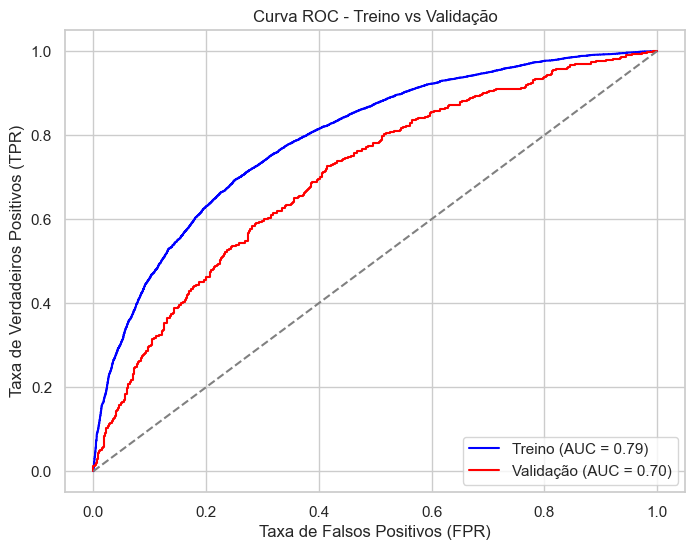

In [29]:
# Curva ROC para treino
fpr_train, tpr_train, _ = roc_curve(data_train_model_1['win'], data_train_model_1['prob'])
auc_train = roc_auc_score(data_train_model_1['win'], data_train_model_1['prob'])

# Curva ROC para validação
fpr_val, tpr_val, _ = roc_curve(data_validatation_model_1['win'], data_validatation_model_1['prob'])
auc_val = roc_auc_score(data_validatation_model_1['win'], data_validatation_model_1['prob'])

# Plotar as curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Treino (AUC = {auc_train:.2f})', color='blue')
plt.plot(fpr_val, tpr_val, label=f'Validação (AUC = {auc_val:.2f})', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Linha de referência (aleatoriedade)

# Personalizações
plt.title('Curva ROC - Treino vs Validação')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

In [30]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    
    # Heatmap sem divisões internas
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                cbar=False, linewidths=1, linecolor='black',
                xticklabels=['Perdeu (0)', 'Venceu (1)'],
                yticklabels=['Perdeu (0)', 'Venceu (1)'])
    
    plt.title(f'Matriz de Confusão - {title}\n', 
             fontsize=14, pad=20, weight='bold')
    plt.xlabel('Predito', fontsize=12)
    plt.ylabel('Real', fontsize=12)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

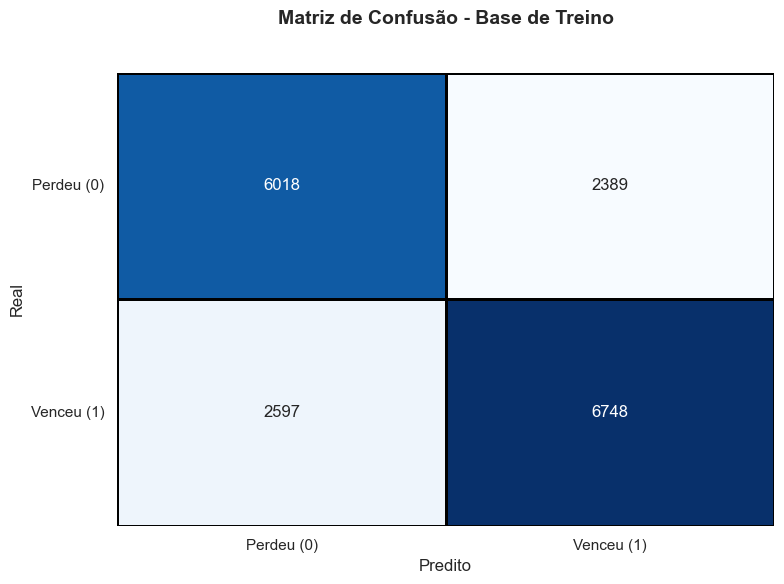

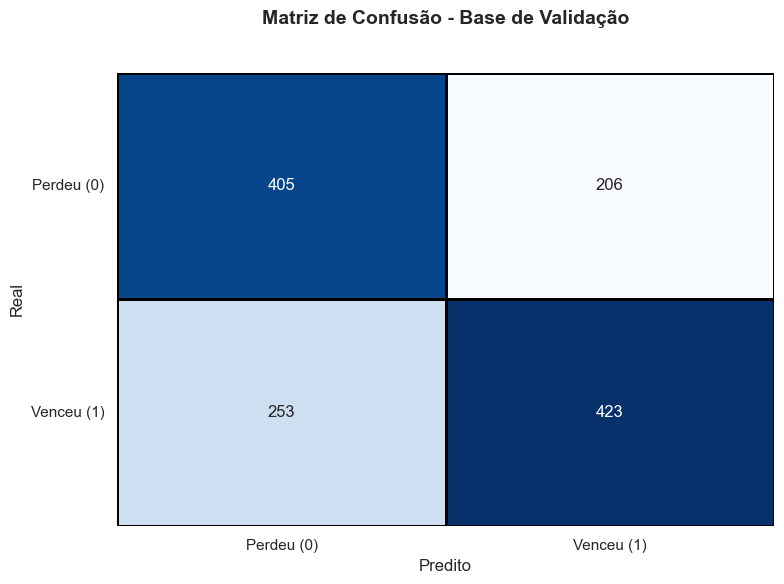

In [31]:
# Plot para base de treino
plot_confusion_matrix(data_train_model_1['win'], 
                     data_train_model_1['pred'], 
                     'Base de Treino')

# Plot para base de validação
plot_confusion_matrix(data_validatation_model_1['win'], 
                     data_validatation_model_1['pred'], 
                     'Base de Validação')

## Modelagem 2 - Todas as Informações

### Ajuste do Modelo

In [97]:
all_columns = pre_game + neutral_goals + vision + comunication + performance

data_train_model_2 = data_train[winner + all_columns].copy()
data_validatation_model_2 = data_validation[winner + all_columns].copy()

In [33]:
# Remoção de conlunas estatísticamente insignificante
remove_columns_model_2 = [
    '100_UTILITY_CLASS', '200_BOTTOM_CLASS', '200_UTILITY_CLASS', 'total_need_vision_pings_diff', 
    'avg_vision_score_diff', 'avg_champion_points_diff', 'total_assist_me_pings_diff',
    'total_command_pings_diff', '100_BOTTOM_CLASS', 'total_all_in_pings_diff', 
    'total_consumables_purchased_diff', 'total_damage_dealt_to_champions_diff',
    'total_detector_wards_placed_diff'
]

data_train_model_2 = data_train_model_2.drop(columns = remove_columns_model_2)
features = [col for col in all_columns if col not in remove_columns_model_2]

# Adicionar `Q()` para colunas que começam com números
features = [f'Q("{col}")' if any(char.isdigit() for char in col.split('_')[0]) else col for col in features]

In [34]:
formula = 'win ~ ' + ' + '.join(features)
model_2 = smf.logit(formula,
                   data = data_train_model_2).fit()

print(model_2.summary())

Optimization terminated successfully.
         Current function value: 0.187066
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                17752
Model:                          Logit   Df Residuals:                    17701
Method:                           MLE   Df Model:                           50
Date:                Mon, 31 Mar 2025   Pseudo R-squ.:                  0.7296
Time:                        13:42:30   Log-Likelihood:                -3320.8
converged:                       True   LL-Null:                       -12280.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  0.0172   

In [35]:
# Avaliação da Colineariedade
vif = pd.DataFrame({
    "Variável": model_2.model.exog_names,
    "VIF": [variance_inflation_factor(model_2.model.exog, i) for i in range(model_2.model.exog.shape[1])]
})

print(vif)

                                  Variável        VIF
0                                Intercept  89.859050
1         Q("100_JUNGLE_CLASS")[T.Fighter]   1.898079
2            Q("100_JUNGLE_CLASS")[T.Mage]   1.269881
3        Q("100_JUNGLE_CLASS")[T.Marksman]   1.531533
4         Q("100_JUNGLE_CLASS")[T.Support]   1.076222
5            Q("100_JUNGLE_CLASS")[T.Tank]   1.505382
6         Q("100_MIDDLE_CLASS")[T.Fighter]   1.511226
7            Q("100_MIDDLE_CLASS")[T.Mage]   1.732370
8        Q("100_MIDDLE_CLASS")[T.Marksman]   1.338631
9         Q("100_MIDDLE_CLASS")[T.Support]   1.031177
10           Q("100_MIDDLE_CLASS")[T.Tank]   1.166587
11           Q("100_TOP_CLASS")[T.Fighter]   8.722726
12              Q("100_TOP_CLASS")[T.Mage]   4.522748
13          Q("100_TOP_CLASS")[T.Marksman]   3.264838
14           Q("100_TOP_CLASS")[T.Support]   1.042238
15              Q("100_TOP_CLASS")[T.Tank]   5.789367
16        Q("200_JUNGLE_CLASS")[T.Fighter]   1.831241
17           Q("200_JUNGLE_C

### Aplicação e Análise do Modelo

In [36]:
# Aplicação do modelo na base de treino e validação
data_train_model_2['prob'] = model_2.predict(data_train_model_2.drop('win', axis=1))
data_validatation_model_2['prob'] = model_2.predict(data_validatation_model_2.drop('win', axis=1))

# Definição de ponto de corte
ponto_corte = data_train_model_2['win'].mean()

# Definição da resposta predita pelo modelo
data_train_model_2['pred'] = (data_train_model_2['prob'] > ponto_corte).astype(int)
data_validatation_model_2['pred'] = (data_validatation_model_2['prob'] > ponto_corte).astype(int)

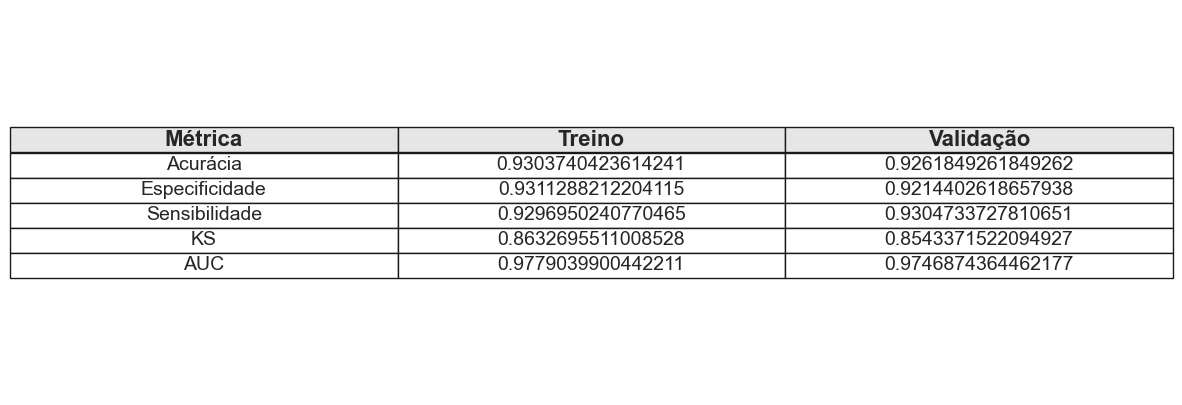

In [37]:
# Tabela consolidada
resultados = pd.DataFrame({
    'Métrica': ['Acurácia', 'Especificidade', 'Sensibilidade', 'KS', 'AUC'],
    'Treino': calcular_metricas(data_train_model_2),
    'Validação': calcular_metricas(data_validatation_model_2)
})

# Criar figura e eixo com um tamanho maior
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')

# Adiciona a tabela
table = ax.table(cellText=resultados.values, 
                colLabels=resultados.columns, 
                cellLoc='center', 
                loc='center',
                colColours=['#f2f2f2'] * len(resultados.columns))

# Ajustar o estilo da tabela
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.5)

for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(16)
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#e6e6e6')
    else:
        cell.set_fontsize(14)

plt.show()

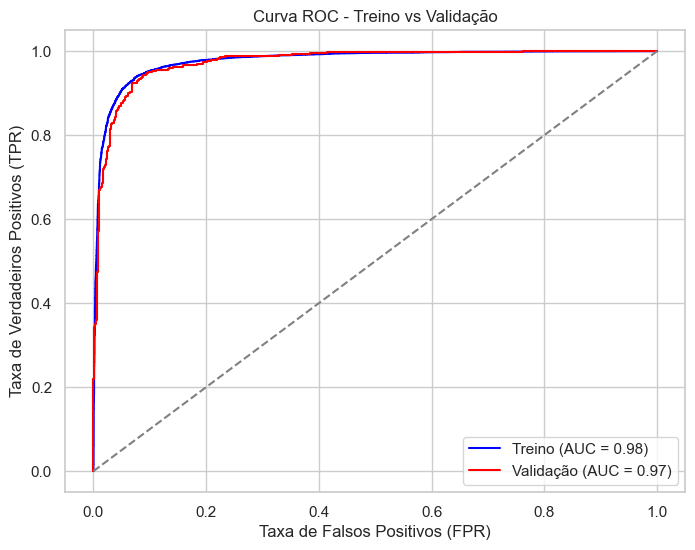

In [38]:
# Curva ROC para treino
fpr_train, tpr_train, _ = roc_curve(data_train_model_2['win'], data_train_model_2['prob'])
auc_train = roc_auc_score(data_train_model_2['win'], data_train_model_2['prob'])

# Curva ROC para validação
fpr_val, tpr_val, _ = roc_curve(data_validatation_model_2['win'], data_validatation_model_2['prob'])
auc_val = roc_auc_score(data_validatation_model_2['win'], data_validatation_model_2['prob'])

# Plotar as curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Treino (AUC = {auc_train:.2f})', color='blue')
plt.plot(fpr_val, tpr_val, label=f'Validação (AUC = {auc_val:.2f})', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Linha de referência (aleatoriedade)

# Personalizações
plt.title('Curva ROC - Treino vs Validação')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

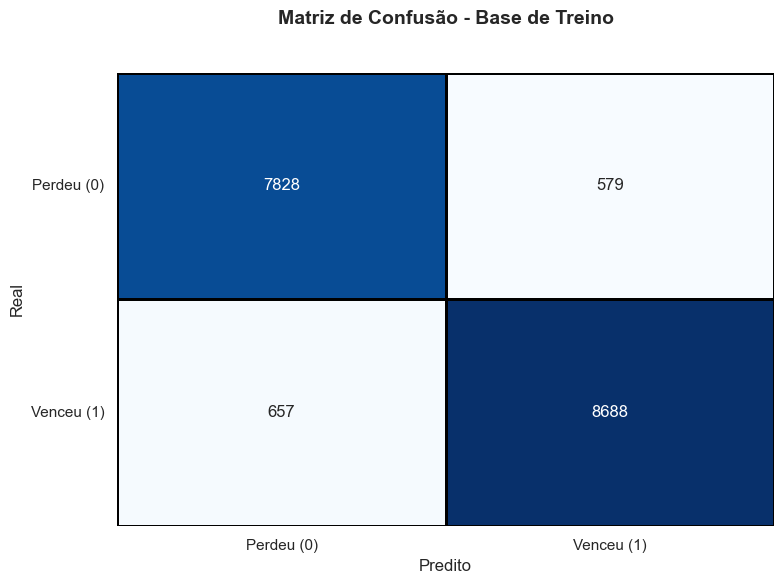

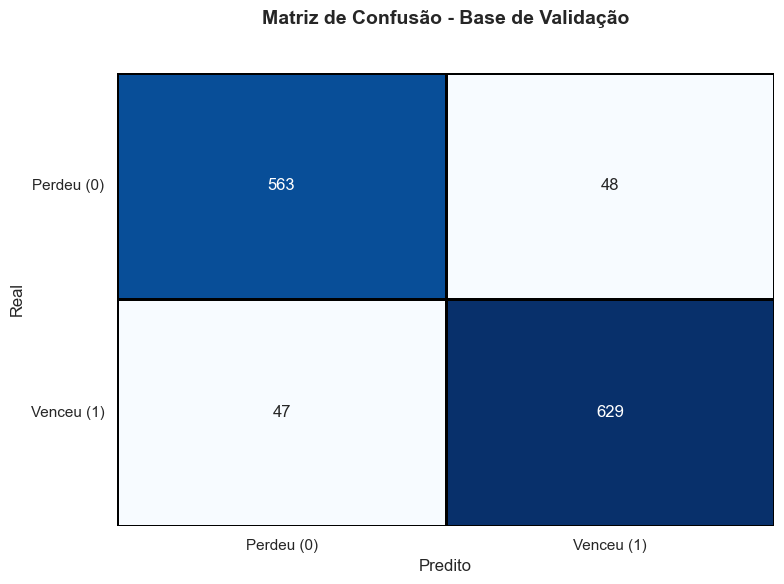

In [39]:
# Plot para base de treino
plot_confusion_matrix(data_train_model_2['win'], 
                     data_train_model_2['pred'], 
                     'Base de Treino')

# Plot para base de validação
plot_confusion_matrix(data_validatation_model_2['win'], 
                     data_validatation_model_2['pred'], 
                     'Base de Validação')

# Machine Learning

In [40]:
# Pré-processamento
pre_processamento = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), make_column_selector(dtype_include = ['int64', 'float64'])),
        ('cat', OneHotEncoder(drop = 'first', handle_unknown='ignore'), make_column_selector(dtype_include = ['object', 'category']))
    ],
    remainder = 'passthrough')

In [41]:
modelos_grid = {
    'ÁRVORE DE DECISÃO': (DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
        'min_samples_leaf': [10, 20, 50, 100],
        'max_depth': [2, 3, 5, 10]
    }),
    'FLORESTA ALEATÓRIA': (RandomForestClassifier(n_jobs = -1), {
        'n_estimators': [10, 50, 100, 200],
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
        'min_samples_leaf': [10, 20, 50, 100],
        'max_depth': [2, 3, 5, 10]
    }),
    'ADABOOST': (AdaBoostClassifier(), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.5]
    }),
    'GRADIENT BOOSTING': (GradientBoostingClassifier(), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5],
        'max_depth': [2, 3, 5, 10],
        'min_samples_leaf': [10, 20, 50, 100]
    }),
    'XGBOOST': (XGBClassifier(n_jobs = -1), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5],
        'max_depth': [2, 3, 5, 10],
        'min_child_weight': [1, 3, 5, 10],
        'gamma': [0, 0.1, 0.5, 1]
    }),
    'LIGHTGBM': (LGBMClassifier(verbose = -1, n_jobs = -1), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5],
        'max_depth': [2, 3, 5, 10],
        'min_data_in_leaf': [10, 20, 50, 100]
    })
}

In [56]:
modelos_rand = {
    'ÁRVORE DE DECISÃO': (DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': np.arange(0, 0.11, 0.01),
        'min_samples_leaf': np.arange(10, 101),
        'max_depth': np.arange(2, 11)
    }),
    'FLORESTA ALEATÓRIA': (RandomForestClassifier(n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': np.arange(0, 0.11, 0.01),
        'min_samples_leaf': np.arange(10, 101),
        'max_depth': np.arange(2, 11)
    }),
    'ADABOOST': (AdaBoostClassifier(), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01)
    }),
    'GRADIENT BOOSTING': (GradientBoostingClassifier(), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_samples_leaf': np.arange(10, 101)
    }),
    'XGBOOST': (XGBClassifier(n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_child_weight': np.arange(1, 11),
        'gamma': np.arange(0, 1.1, 0.1)
    }),
    'LIGHTGBM': (LGBMClassifier(verbose = -1, n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_data_in_leaf': np.arange(10, 101)
    })
}

## Modelagem 1 - Informações Pré-Jogo

In [145]:
X = data_train[pre_game].copy().reset_index(drop=True)
y = data_train['win'].copy().reset_index(drop=True)

X_sample = X
y_sample = y

X_validation = data_validation[pre_game].copy().reset_index(drop=True)
y_validation = data_validation['win'].copy().reset_index(drop=True)

### Pré-processamento e Modelos 

In [146]:
X_transformed = pre_processamento.fit_transform(X)
X_sample_transformed = X_transformed[X_sample.index]
X_validation_transformed = pre_processamento.transform(X_validation)

melhor_algoritmo = ""
melhor_modelo = None
melhor_score = float('-inf')

inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

In [45]:
# Avaliação de modelos por validação cruzada aninhada
for nome, (algoritmo, parametros) in modelos_grid.items():

  # Métricas de interesse
  scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}

  # Escolha entre grid search ou random search. No random search, altere a métrica que deseja otimizar em 'refit' e a quantidade de iterações, se for necessário
  grid_search = GridSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'AUC', n_jobs = -1)
  # random_search = RandomizedSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123, n_jobs = -1)
  nested_scores = cross_validate(grid_search, X = X_sample_transformed, y = y_sample, cv = outer_cv, scoring = scoring, n_jobs = -1)

  # Verificando se o modelo atual é o melhor
  if np.mean(nested_scores['test_AUC']) > melhor_score:
      melhor_algoritmo = nome
      melhor_modelo = grid_search
      melhor_score = np.mean(nested_scores['test_AUC'])

  # Resultados
  # Observação: os cálculos de acurácia balanceada e sensibilidade consideram ponto de corte = 0,50 por padrão; logo, só devem ser considerados para bases balanceadas
  print(f'--- {nome} ---')
  print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
  print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))
  print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
  print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))
  print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
  print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))
  print("")

print(f"O melhor algoritmo é {melhor_algoritmo}, para os valores de hiperparâmetros testados.")

--- ÁRVORE DE DECISÃO ---
Média de AUC: 0.785
D.P. de AUC: 0.006
Média de Acurácia Balanceada: 0.709
D.P. de Acurácia Balanceada: 0.005
Média de Sensibilidade: 0.775
D.P. de Sensibilidade: 0.031

--- FLORESTA ALEATÓRIA ---
Média de AUC: 0.787
D.P. de AUC: 0.008
Média de Acurácia Balanceada: 0.717
D.P. de Acurácia Balanceada: 0.01
Média de Sensibilidade: 0.738
D.P. de Sensibilidade: 0.031

--- ADABOOST ---
Média de AUC: 0.792
D.P. de AUC: 0.007
Média de Acurácia Balanceada: 0.716
D.P. de Acurácia Balanceada: 0.009
Média de Sensibilidade: 0.745
D.P. de Sensibilidade: 0.013

--- GRADIENT BOOSTING ---
Média de AUC: 0.791
D.P. de AUC: 0.006
Média de Acurácia Balanceada: 0.715
D.P. de Acurácia Balanceada: 0.009
Média de Sensibilidade: 0.742
D.P. de Sensibilidade: 0.01

--- XGBOOST ---
Média de AUC: 0.791
D.P. de AUC: 0.006
Média de Acurácia Balanceada: 0.715
D.P. de Acurácia Balanceada: 0.009
Média de Sensibilidade: 0.74
D.P. de Sensibilidade: 0.01

--- LIGHTGBM ---
Média de AUC: 0.791
D.P. 

### Ajuste do Modelo

In [46]:
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}

modelo_final = RandomizedSearchCV(melhor_modelo.estimator, modelos_grid[melhor_algoritmo][1], cv = cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123, n_jobs = -1)
modelo_final.fit(X_sample_transformed, y_sample)

print(f"Melhores hiperparâmetros para {melhor_algoritmo}: {modelo_final.best_params_}")

The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.


Melhores hiperparâmetros para ADABOOST: {'n_estimators': 200, 'learning_rate': 0.1}


### Importância das Features

In [147]:
# Auxiliar: nomes das features após pré-processamento
features_qualitativas = X_sample.select_dtypes(include = ['object', 'category']).columns
features_qualitativas = pre_processamento.named_transformers_['cat'].get_feature_names_out(features_qualitativas) if not features_qualitativas.empty else features_qualitativas
features_quantitativas = X_sample.select_dtypes(include = ['int64', 'float64']).columns
features = list(features_quantitativas) + list(features_qualitativas)

In [148]:
# Cálculo de medida de importância de Gini
importancias = modelo_final.best_estimator_.feature_importances_

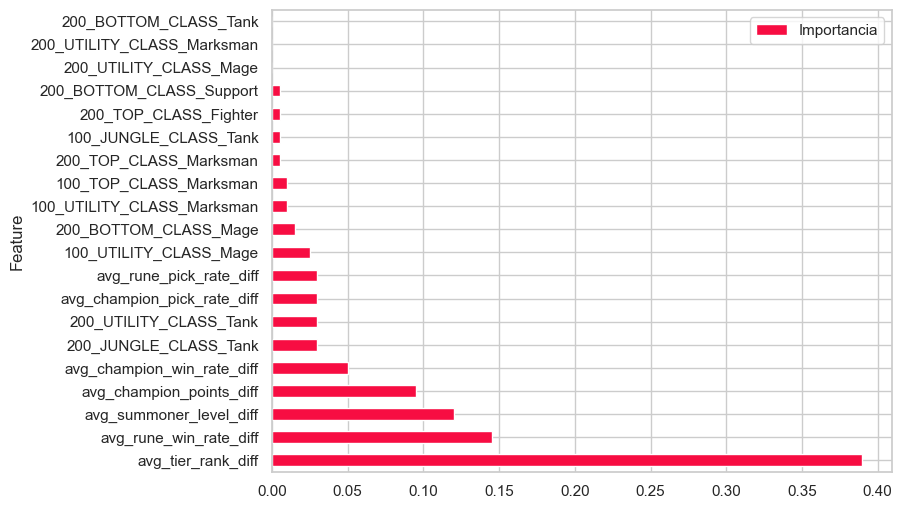

In [149]:
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = False)
top_20 = df_importancias.head(20)
top_20.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

### Aplicação do Modelo

In [50]:
# Transformar a base de validação
y_prob = modelo_final.best_estimator_.predict_proba(X_validation_transformed)[:,1]
ponto_corte = y_sample.astype(int).mean()
X_validation.loc[:, 'y_pred'] = (y_prob >= ponto_corte).astype(int)

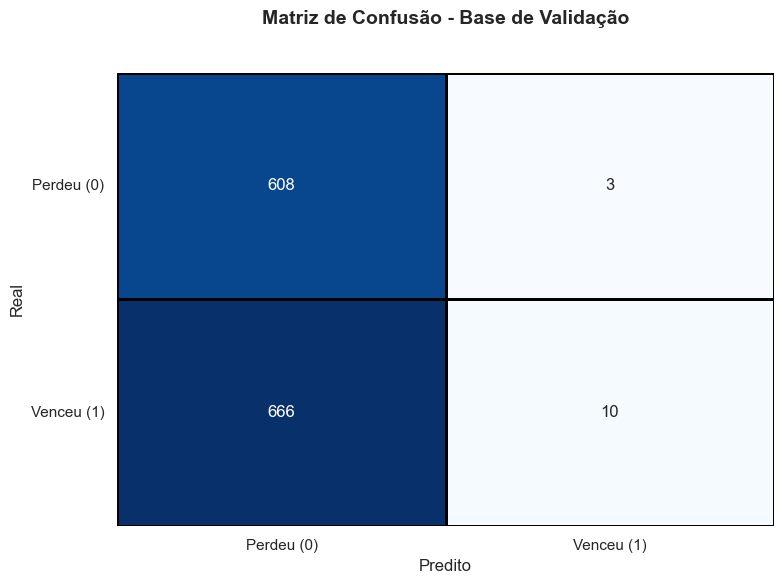

In [51]:
plot_confusion_matrix(y_validation, 
                     X_validation['y_pred'],
                     'Base de Validação')

## Modelagem 2 - Todas as Informações

In [161]:
X_train_model_2 = data_train[all_columns].copy().reset_index(drop=True)
y_train_model_2 = data_train['win'].copy().reset_index(drop=True)

X_sample = X_train_model_2
y_sample = y_train_model_2

X_validation_model_2 = data_validation[all_columns].copy()
y_validation_model_2 = data_validation['win'].copy()

#### Pré-processamento e Modelos

In [162]:
X_train_model_2 = pre_processamento.fit_transform(X_train_model_2)
X_train_model_2 = X_train_model_2[X_sample.index]

X_validation_model_2 = pre_processamento.transform(X_validation_model_2)

melhor_algoritmo_model_2 = ""
melhor_modelo_model_2 = None
melhor_score_model_2 = float('-inf')

inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

In [57]:
# Avaliação de modelos por validação cruzada aninhada
for nome, (algoritmo, parametros) in modelos_rand.items():

  # Métricas de interesse
  scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}

  # Escolha entre grid search ou random search. No random search, altere a métrica que deseja otimizar em 'refit' e a quantidade de iterações, se for necessário
  # grid_search = GridSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'AUC', n_jobs = -1)
  random_search = RandomizedSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123, n_jobs = -1)
  nested_scores = cross_validate(random_search, X = X_train_model_2, y = y_train_model_2, cv = outer_cv, scoring = scoring, n_jobs = -1)

  # Verificando se o modelo atual é o melhor
  if np.mean(nested_scores['test_AUC']) >= melhor_score_model_2:
      melhor_algoritmo_model_2 = nome
      melhor_modelo_model_2 = random_search
      melhor_score_model_2 = np.mean(nested_scores['test_AUC'])

  # Resultados
  # Observação: os cálculos de acurácia balanceada e sensibilidade consideram ponto de corte = 0,50 por padrão; logo, só devem ser considerados para bases balanceadas
  print(f'--- {nome} ---')
  print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
  print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))
  print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
  print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))
  print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
  print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))
  print("")

print(f"O melhor algoritmo é {melhor_algoritmo_model_2}, para os valores de hiperparâmetros testados.")

--- ÁRVORE DE DECISÃO ---
Média de AUC: 0.969
D.P. de AUC: 0.002
Média de Acurácia Balanceada: 0.923
D.P. de Acurácia Balanceada: 0.004
Média de Sensibilidade: 0.92
D.P. de Sensibilidade: 0.005

--- FLORESTA ALEATÓRIA ---
Média de AUC: 0.98
D.P. de AUC: 0.001
Média de Acurácia Balanceada: 0.926
D.P. de Acurácia Balanceada: 0.004
Média de Sensibilidade: 0.931
D.P. de Sensibilidade: 0.003

--- ADABOOST ---
Média de AUC: 0.986
D.P. de AUC: 0.002
Média de Acurácia Balanceada: 0.943
D.P. de Acurácia Balanceada: 0.003
Média de Sensibilidade: 0.947
D.P. de Sensibilidade: 0.003

--- GRADIENT BOOSTING ---
Média de AUC: 0.987
D.P. de AUC: 0.001
Média de Acurácia Balanceada: 0.943
D.P. de Acurácia Balanceada: 0.003
Média de Sensibilidade: 0.946
D.P. de Sensibilidade: 0.003

--- XGBOOST ---
Média de AUC: 0.987
D.P. de AUC: 0.001
Média de Acurácia Balanceada: 0.943
D.P. de Acurácia Balanceada: 0.001
Média de Sensibilidade: 0.946
D.P. de Sensibilidade: 0.002

--- LIGHTGBM ---
Média de AUC: 0.987
D.P

#### Ajuste do Modelo

In [155]:
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}

modelo_final_model_2 = RandomizedSearchCV(melhor_modelo_model_2.estimator, modelos[melhor_algoritmo_model_2][1], cv = cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123, n_jobs = -1)
modelo_final_model_2.fit(X_train_model_2, y_train_model_2)

print(f"Melhores hiperparâmetros para {melhor_algoritmo_model_2}: {modelo_final_model_2.best_params_}")

Melhores hiperparâmetros para XGBOOST: {'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1}


#### Importância das Features

In [163]:
# Auxiliar: nomes das features após pré-processamento
features_qualitativas = X_sample.select_dtypes(include = ['object', 'category']).columns
features_qualitativas = pre_processamento.named_transformers_['cat'].get_feature_names_out(features_qualitativas) if not features_qualitativas.empty else features_qualitativas
features_quantitativas = X_sample.select_dtypes(include = ['int64', 'float64']).columns
features_model_2 = list(features_quantitativas) + list(features_qualitativas)

In [164]:
# Cálculo de medida de importância de Gini
importancias_model_2 = modelo_final_model_2.best_estimator_.feature_importances_

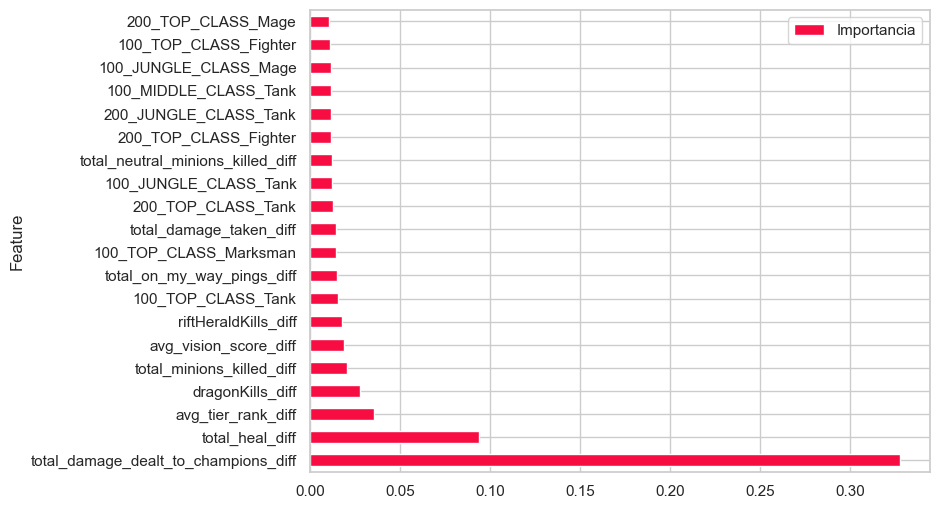

In [165]:
# Gráfico das importâncias de Gini
df_importancias_model_2 = pd.DataFrame({'Feature': features_model_2, 'Importancia': importancias_model_2}).sort_values(by = 'Importancia', ascending = False)
top_20_model_2 = df_importancias_model_2.head(20)
top_20_model_2.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

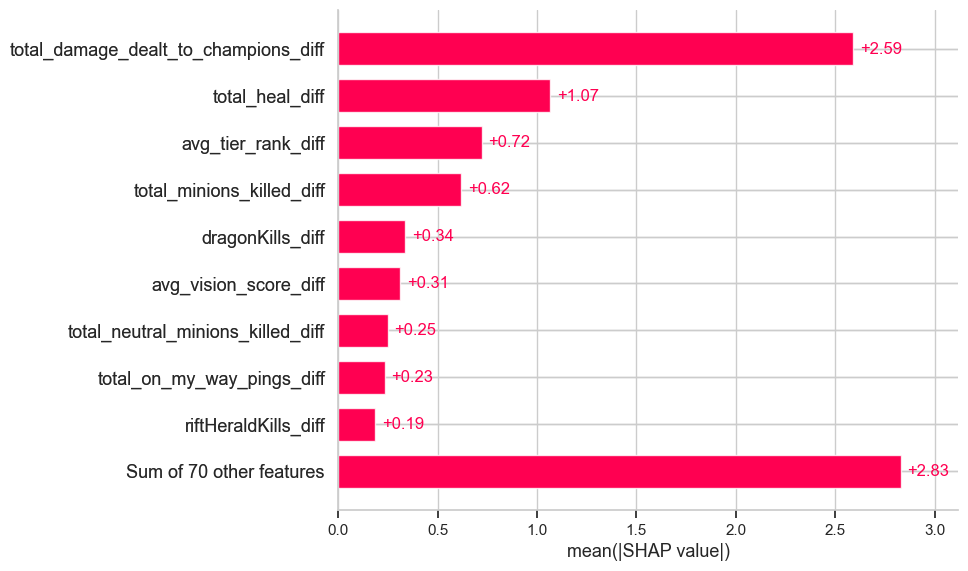

In [166]:
explainer_model_2 = shap.Explainer(modelo_final_model_2.best_estimator_)
valores_shap_model_2 = explainer_model_2(X_train_model_2)

shap.plots.bar(shap.Explanation(values = valores_shap_model_2, feature_names = features_model_2))

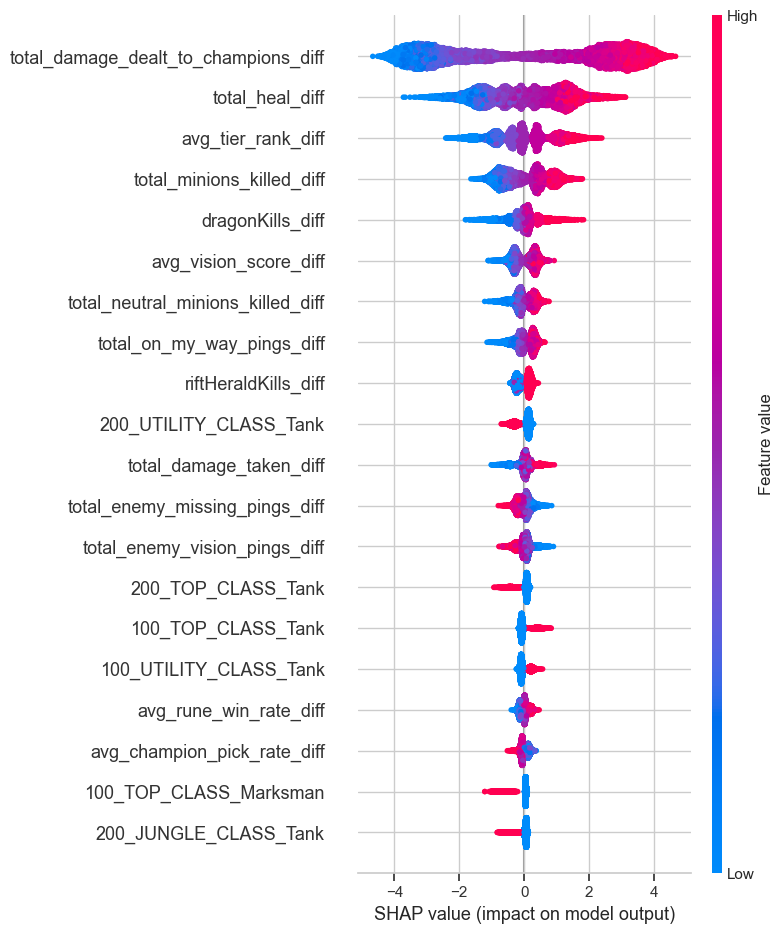

In [167]:
shap.summary_plot(shap.Explanation(values = valores_shap_model_2, feature_names = features_model_2))

#### Aplicação do Modelo

In [168]:
# Transformar a base de validação
y_prob_model_2 = modelo_final_model_2.best_estimator_.predict_proba(X_validation_model_2)[:,1]
ponto_corte = y_train_model_2.astype(int).mean()
data_validation.loc[:, 'y_pred'] = (y_prob_model_2 >= ponto_corte).astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


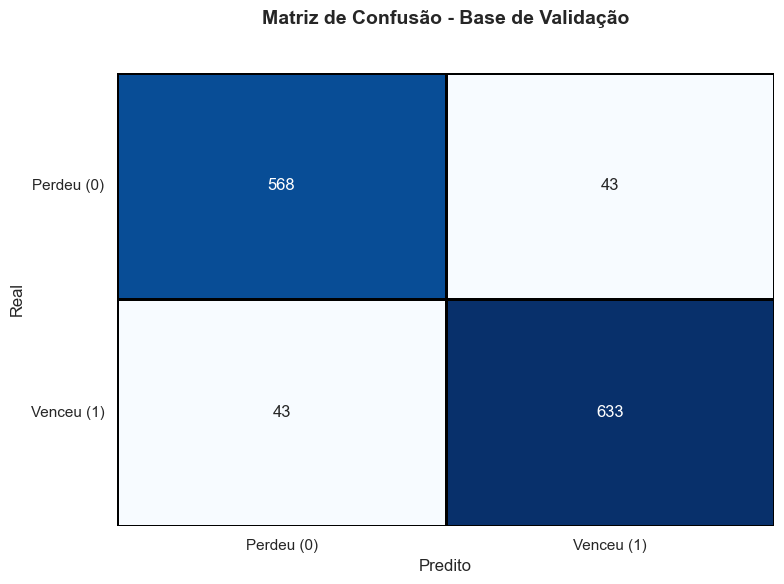

In [169]:
plot_confusion_matrix(y_validation_model_2, 
                     data_validation['y_pred'],
                     'Base de Validação')